# Solving the lizard problem

By: Jacobo Fernández-Vargas and Luca Citi

We are now going to solve from beginning to end the problem that was left as
exercise in the second lab.

This will allow us to go through all the steps involved in creating and testing
a machine learning model.

It is important to know that this dataset was not intended to use for
classifications purposes, so we may not get good results or it may be a trivial problem.

Regardless, this example will serve its purpose of seeing an example of building a
pipeline from start to end. We will also point to some common errors.

## The data

The data comes from a paper [1] that aimed at finding differences
in the behaviour of lizards depending on the colour of their abdomen
(yellow, white or orange).

For example the authors wanted to know if lizards of a specific colour
have bigger territories. Each sample is one observation of a specific lizard.

The authors of the paper could not find any differences.
We are going to use the dataset in a different way
(i.e. predicting the colour of a lizard observed at a specific location at a given time).

[1] https://onlinelibrary.wiley.com/doi/10.1002/ece3.6659

## Loading the data

Since we know that the data is not ready to use in numpy,
we use pandas to load the data and preprocess it.

In [47]:
import pandas as pd

In [48]:
import sklearn.preprocessing

data = pd.read_csv('exercise1.csv')
data

,ID_e,E,N,Sex,Date,Hour,Cell,Label
0,e1f1,5.583066,1.175189,f,05/6/2018,12:27,e1,o
1,e1f1,5.325020,0.962680,f,21/6/2018,10:20,e1,o
2,e1f1,3.412439,0.947501,f,21/6/2018,14:25,e1,o
3,e1f1,3.761561,2.010046,f,21/6/2018,12:30,e1,o
4,e1f1,NaN,1.144831,f,15/6/2018,12:06,e1,o
...,...,...,...,...,...,...,...,...
7184,e9m9,1.103858,NaN,m,25/5/2018,15:40,e9,y
7185,e9m9,3.699470,NaN,m,25/5/2018,17:21,e9,y
7186,e9m9,1.766447,NaN,m,24/5/2018,16:26,e9,y
7187,e9m9,0.497900,1.169597,m,23/5/2018,12:30,e9,y


The first thing that we are going to do is to merge the Date and Hour columns.
For this, we will concatenate the strings that contain the date and time
and then transform them into a datetime object.

We will then transform the result into a number
(the number of days since a reference time point).
Finally, we will remove the extra column.

In [49]:
data['Date'] = pd.to_datetime(data['Date'] + ' ' + data['Hour'])
data = data.drop('Hour', axis=1)
time0 = pd.Timestamp('2018-01-01 00:00:00')
data['Date'] = (data['Date'] - time0) / pd.Timedelta(1, 'day')
data.head()

,ID_e,E,N,Sex,Date,Cell,Label
0,e1f1,5.583066,1.175189,f,125.518750,e1,o
1,e1f1,5.325020,0.962680,f,171.430556,e1,o
2,e1f1,3.412439,0.947501,f,171.600694,e1,o
3,e1f1,3.761561,2.010046,f,171.520833,e1,o
4,e1f1,NaN,1.144831,f,165.504167,e1,o


We will now transform all categorical values into numerical ones.
For the sex we will use just 0 and 1.
For the column 'Cell', we could either use the number in the cell
or convert the field using a one-hot-encoder.

It's hard  to decide which option is best without having additional details
about the data collection. For simplicity, we will just use the cell number.

In [50]:
cleanup = {"Sex": {"f":0, "m":1},
          "Cell": {"e1":1, "e2":2, "e3":3, "e4":4, "e5":5, "e6":6, "e7":7, "e8":8, "e9":9, "e10":10}
          }
data.replace(cleanup, inplace=True)
data.head()

,ID_e,E,N,Sex,Date,Cell,Label
0,e1f1,5.583066,1.175189,0,125.518750,1,o
1,e1f1,5.325020,0.962680,0,171.430556,1,o
2,e1f1,3.412439,0.947501,0,171.600694,1,o
3,e1f1,3.761561,2.010046,0,171.520833,1,o
4,e1f1,NaN,1.144831,0,165.504167,1,o


If we look at the data, we can see that the ID is just a concatenation of the cell,
the sex and the lizard number.
Because of this, there is a perfect mapping between the ID and the label.
However, instead of removing it right away,
we are going to use it to fill the missing values in E and N.

We will first transform the ID into a numeric value using the method `factorize`.

In [51]:
data['ID_e'] = pd.factorize(data.ID_e)[0]
data

,ID_e,E,N,Sex,Date,Cell,Label
0,0,5.583066,1.175189,0,125.518750,1,o
1,0,5.325020,0.962680,0,171.430556,1,o
2,0,3.412439,0.947501,0,171.600694,1,o
3,0,3.761561,2.010046,0,171.520833,1,o
4,0,NaN,1.144831,0,165.504167,1,o
...,...,...,...,...,...,...,...
7184,179,1.103858,NaN,1,144.652778,9,y
7185,179,3.699470,NaN,1,144.722917,9,y
7186,179,1.766447,NaN,1,143.684722,9,y
7187,179,0.497900,1.169597,1,142.520833,9,y


Finally, we need to change the label.
We could use a one-hot encoder for this,
as the label seems to be a categorical value with no ordinal relationship.
However, most classifiers need a single output
and treat multiclass problems as one vs. all approach,
so using a one-hot encoder is not strictly required.

A notable exception to this are artificial neural networks
(so if we want to use ANN we would need to change the following lines
to use a one-hot encoder).

Most classifiers that deal with more than 2 classes tend to do the probability
or something along those lines for what each thing is
`[prob of A, prob of B, prob of C]`

Decision trees and neural networks work well with more than 2 classes.
Most other classifiers don't.

In [52]:
data['Label'] = pd.factorize(data.Label)[0]

Now we are ready to transfer the data to numpy arrays.

In [53]:
import numpy as np
x = data.loc[:, data.columns != 'Label'].to_numpy()
y = data.loc[:, 'Label'].to_numpy()

We now check for missing values.

In [54]:
np.sum(np.isnan(x),0)

array([  0, 387, 390,   0,   0,   0])

## Prediction
For the prediction we are going to use a Random Forest approach,
which uses ensembles of decision trees.
We are going to tune its main parameters: the number of trees and the maximum depth.

For the imputation of the missing values we will use the average based on the ID.
Considering that decision trees ignore the magnitude of the inputs,
we will not use any normalisation or scaling.

Also, we will remove the ID_e column as we know that it's a false predictor.

Finally, as we know that the data is groupped by lizard,
we will use cross validation with shuffling.

Let us now start by creating the imputer

* Grouping by each lizard, finding the mean position for each lizard
* If we find a missing value:
    * If we've seen that lizard before
        * We fill in its position to be the mean position for that lizard
    * If we haven't seen that lizard before
        * We fill in its position with the mean position for all lizards

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

# We need to create a pipeline module for our special imputation method
class GroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self, apply_to_columns, group_by_column):
        self.apply_to_columns = apply_to_columns
        self.group_by_column = group_by_column

    def fit(self, X, y=None):
        self.global_mean = np.nanmean(X[:, self.apply_to_columns], axis=0)  # compute the global mean to be used as fallback method
        groups = np.unique(X[:, self.group_by_column])  # get the groups in the set
        self.group_means = {}
        for group in groups:
            selected = X[:, self.group_by_column] == group  # select rows belonging to the group 'group'
            group_means = np.nanmean(X[np.ix_(selected, self.apply_to_columns)], axis=0)  # compute group means
            group_means[np.isnan(group_means)] = self.global_mean[np.isnan(group_means)]  # if any mean is missing, use global mean
            self.group_means[group] = group_means  # store for later use
        return self

    def transform(self, X, y=None):
        nans = np.isnan(X[:, self.apply_to_columns])
        if not np.any(nans):
            return X  # return X unchanged if there are no missing values
        X = np.copy(X)  # work on a copy of the data
        groups = np.unique(X[:, self.group_by_column])  # get the groups in the set
        for group in groups:
            selected = X[:, self.group_by_column] == group  # select rows belonging to the group 'group'
            group_means = self.group_means.get(group, self.global_mean)  # retrieve saved group means if any, otherwise use global mean
            for j in range(len(self.apply_to_columns)):
                X[np.logical_and(nans[:, j], selected), self.apply_to_columns[j]] = group_means[j]  # replace nans
        return X

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X, y)

We can now build the pipleline.
Note that we need to remove the ID_e column as it's a false predictor.

We then train the random forest classifier, tuning its parameters using a grid search.

Note that we are not calling to individual methods for `fit` and `predict`,
everything is performed through the `cross_validate` method.

We use `ColumnTransformer` to drop the ID_e column without any problems.

`pipe` is the pipeline we're using. Sums up the full pipeline stuff in a few lines of code.

In [56]:
import sklearn.metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold, GridSearchCV


cv = KFold(shuffle=True) # perform CV after shuffling the data
# SHOULD ALWAYS SHUFFLE THE DATA IF WE ALREADY KNOW STUFF ABOUT THE DATA!
# but may not always be a good idea, such as if we're using 'leave one out' validation
# (where we train using all but one of the lizards, then test on the other lizard)

imputer = GroupImputer(apply_to_columns=[1, 2], group_by_column=0)
# impute cols 1 and 2 using groups in col 0

dropper = ColumnTransformer([('dropper', 'drop', 0)], remainder='passthrough')
# drop column 0 (ID_e) and leave others unchanged

rf = RandomForestClassifier()
# We're using the RandomForestClassifier for classification

pipe = Pipeline([('imputer', imputer), ('dropper', dropper), ('rf', rf)])
# build pipeline
# as far as sklearn cares, this pipeline is a classifier.

# input data -> imputer -> dropper -> rf -> classified data

param_grid = {
    'rf__n_estimators': np.arange(3, 51, 6), # test forests of different sizes
    'rf__max_depth': [3, 5, 10, 20]          # test different values for max_depth
}

And here we cross-validate stuff

In [57]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
scores = cross_validate(search, x, y, scoring=['accuracy'], cv=cv, return_estimator=True)

We now have the results for 5 folds for each configuration of the classifer.


With the results,
we can explore the parameters to know the best combination of
number of trees and maximum depth.

We can do this on all data since this is only done for information purposes,
not for model selection (which is done in nested CV by `GridSearchCV`).

Since we performed a five-fold validations, we have five values for each combination,
so we need to calculate the average.

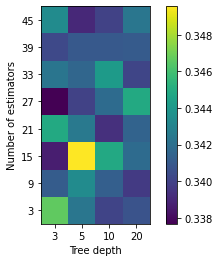

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt

features = np.zeros((len(param_grid['rf__n_estimators']), len(param_grid['rf__max_depth'])))
for estimator in scores['estimator']:
    features += estimator.cv_results_['mean_test_score'].reshape(features.shape)
features /= len(scores['estimator'])

im = plt.imshow(features, origin='lower')
plt.colorbar(im)
plt.xticks(np.arange(len(param_grid['rf__max_depth'])), param_grid['rf__max_depth'])
plt.yticks(np.arange(len(param_grid['rf__n_estimators'])), param_grid['rf__n_estimators'])
plt.xlabel("Tree depth")
plt.ylabel("Number of estimators")
plt.show()

No meaningful difference between these classifiers,
but all equally bad -> all equally good.

### Overall performance
Finally, we can look at the overall performance of our pipeline.
The scores across all (outer) CV folds and its average are as follows:

In [59]:
print('Fold accuracy', scores['test_accuracy'])
print('Average accuracy', np.mean(scores['test_accuracy']))

Fold accuracy [0.3922114  0.3852573  0.4054242  0.42767733 0.46555324]
Average accuracy 0.41522469446952825


### Assumptions for cross-validation

The CV approach shown above shuffles all data before building the different folds.
Therefore some observations of the same lizard may end up in the training set and
some in the test set.
Is this OK? Yes and no.
It depends on the real-life situation that the CV is supposed to be a proxy for.
This CV scheme is fine if we intend to use our system to identify the color of a
lizard that we observe at a given time in a given place, assuming that we may have
already observed that same lizard.

What if we want to build a system that tries to predict the color of a new
lizard never observed before? In this case we need to create our folds making
sure that each lizard's data is never split between different folds.

We can do this using [`GroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html)
and passing the `groups` argument to `cross_validate`.
This time we won't be able to impute based on the lizard ID
(because each test-fold lizard ID will not be present in the corresponding training set)
but we could use the cell number instead.
Also, for simplicity we will not use the grid search.

In [76]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

group = x[:, 0]
# the column 0 is our group (i.e. each lizard's ID)

cv = GroupKFold(n_splits=3)
# split into into 3 groups

imputer = GroupImputer(apply_to_columns=[1, 2], group_by_column=5)
# use column 5 (cell) to impute missing coordinates

dropper = ColumnTransformer([('dropper', 'drop', 0)], remainder='passthrough')
# drop column 0 (ID) and leave others unchanged

scl = StandardScaler()
rf = RandomForestClassifier()
pipe = Pipeline([
    ('imputer', imputer),
    ('dropper', dropper),
    ('scaler', scl),
    ('rf', rf)
])

scores = cross_validate(
    pipe, x, y,
    scoring=['accuracy'],
    cv=cv,
    groups=group,
    return_estimator=True
)

Let's make sure that indeed `GroupKFold` splits the data
so that each lizard's data is either completely in the training folds or in the test fold.

In [77]:
for train, test in cv.split(x, groups=group):
    print('Lizard IDs in training set\n', np.unique(x[train, 0]))
    print('Lizard IDs in test set\n', np.unique(x[test, 0]))
    print('---')

Lizard IDs in training set
 [  0.   4.   5.   6.   7.   8.  10.  11.  14.  15.  16.  17.  19.  20.
  22.  23.  24.  25.  26.  27.  30.  31.  32.  34.  35.  36.  43.  44.
  46.  49.  50.  51.  53.  54.  55.  56.  57.  62.  64.  65.  66.  67.
  68.  69.  70.  71.  72.  73.  76.  77.  78.  79.  80.  82.  83.  84.
  88.  89.  90.  91.  93.  96.  97.  99. 100. 102. 103. 104. 105. 106.
 107. 108. 110. 111. 112. 113. 115. 116. 117. 118. 121. 123. 124. 127.
 130. 131. 132. 133. 134. 135. 141. 142. 143. 144. 145. 148. 150. 151.
 152. 153. 154. 156. 157. 158. 159. 160. 161. 164. 166. 167. 168. 169.
 170. 172. 173. 174. 175. 177. 178. 179.]
Lizard IDs in test set
 [  1.   2.   3.   9.  12.  13.  18.  21.  28.  29.  33.  37.  38.  39.
  40.  41.  42.  45.  47.  48.  52.  58.  59.  60.  61.  63.  74.  75.
  81.  85.  86.  87.  92.  94.  95.  98. 101. 109. 114. 119. 120. 122.
 125. 126. 128. 129. 136. 137. 138. 139. 140. 146. 147. 149. 155. 162.
 163. 165. 171. 176.]
---
Lizard IDs in training set
 

Finally, we can look at the scores:

In [78]:
print('Fold accuracy', scores['test_accuracy'])
print('Average accuracy', np.mean(scores['test_accuracy']))

Fold accuracy [0.21693784 0.22412354 0.24207012]
Average accuracy 0.22771049835295418


We see that the performance is quite poor. Let's have a look at the confusion matrix

For each class, how many times did we predict that it was each class?

Columns: predicted values

Rows: real value

```
       | A out | B out | C out
------ | ----- | ----- | -----
real A | Right | Wrong | Wrong
real B | Wrong | Right | Wrong
real C | Wrong | Wrong | Right
```

In [79]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(pipe, x, y, cv=cv, groups=group)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[642, 863, 970],
       [927, 423, 885],
       [975, 932, 572]], dtype=int64)

Our performace is worse than random.
It's interesting how the correct class is always the one that is predicted least often
(i.e. the diagonal is smaller than the other values).

Is this an artifact of our algorithm,
of the experimental design,
or maybe lizards of the same colour tend to stay away from each other?

Answering this very interesting question is beyond the scope of this notebook ;-)



Info for the assignment:
* If stuff is being printed, explain why it's being printed.
* Make some nice matplotlib graphs!
    * Proper axes, proper size, proper colours, etc.
    * takes time, but looks nice.
    * Try not to use too many colours!
        * Try using shapes for data points I guess to make it look legit
